In [144]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout, LayerNormalization, Attention, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



In [145]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected by TensorFlow")

1 Physical GPUs, 1 Logical GPUs


In [146]:
company_symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "SSNLF", "SONY", 
    "BBY", "COST", "WMT", "INTC", "AMD", "TXN", "QCOM", "AVGO", "T", 
    "VZ", "TMUS", "CSCO", "CRM", "ADBE", "ORCL", "NOW", "V", "MA", 
    "PYPL", "SQ", "TSLA", "GM", "F", "NIO", "RIVN", "JNJ", "PFE", 
    "MRNA", "GILD", "AMGN", "BA", "GE", "HON", "MMM", "CAT", "XOM", 
    "CVX", "NEE", "DUK", "SLB"
]

In [147]:
df = pd.read_csv("data/AAPL.csv")
print(df.head())

   Unnamed: 0  1. open  2. high    3. low  4. close  5. volume
0  2024-06-04  194.635  195.320  193.0342    194.35   47471445
1  2024-06-03  192.900  194.990  192.5200    194.03   50080539
2  2024-05-31  191.440  192.570  189.9100    192.25   75158277
3  2024-05-30  190.760  192.180  190.6300    191.29   49947941
4  2024-05-29  189.610  192.247  189.5100    190.29   53068016


In [148]:
# Load all the data in the company_symbols list
data = {}
for symbol in company_symbols:
    df = pd.read_csv(f"data/{symbol}.csv")
    if symbol == 'AAPL':
        df = df.rename(columns={"Unnamed: 0": "Date",'1. open':'AAPL_1. open',"4. close":"AAPL_4. close"})
        df = df.drop(columns=['2. high','3. low','5. volume'])
    else:
        df = df.drop(columns=["Unnamed: 0",f"2. high",f"3. low",f"4. close",f"5. volume"])
        df = df.rename(columns={"1. open":f"{symbol}"})
    data[symbol] = df

combined_df = pd.concat(data.values(), axis=1)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])



combined_df['Original_Date'] = combined_df['Date']
# Convert the datetime to timestamp (number of seconds since 1970-01-01)
combined_df['Date'] = (combined_df['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# Sort the DataFrame by 'Date' in ascending order
combined_df = combined_df.sort_values('Date', ascending=True)

# Reset the index of the DataFrame
combined_df = combined_df.reset_index(drop=True)
print(combined_df.head())

        Date  AAPL_1. open  AAPL_4. close   MSFT  GOOGL   AMZN  META   NVDA  \
0  941414400         80.00          77.62  93.25    NaN  68.06   NaN  21.75   
1  941500800         78.00          80.25  92.75    NaN  69.75   NaN  23.94   
2  941587200         81.62          81.50  92.94    NaN  68.19   NaN  26.00   
3  941673600         82.06          83.62  92.31    NaN  67.19   NaN  27.75   
4  941760000         84.62          88.31  91.81    NaN  64.75   NaN  30.00   

   SSNLF    SONY  ...      GE    HON    MMM    CAT    XOM    CVX    NEE  \
0    NaN  158.75  ...  133.63  57.00  95.13  55.31  74.06  90.56  50.19   
1    NaN  156.69  ...  129.69  57.62  94.75  55.38  74.37  91.25  50.00   
2    NaN  159.00  ...  132.88  56.00  94.63  56.75  74.62  89.94  49.81   
3    NaN  159.75  ...  132.50  56.88  94.88  56.75  73.69  89.06  49.44   
4    NaN  162.62  ...  133.19  56.00  95.50  55.00  73.00  88.75  49.19   

     DUK    SLB  Original_Date  
0  56.44  61.25     1999-11-01  
1  56.63

In [149]:
combined_df.to_csv("data/combined1.csv")

In [150]:
print(combined_df.tail())


            Date  AAPL_1. open  AAPL_4. close     MSFT   GOOGL    AMZN  \
6182  1716940800       189.610         190.29  425.690  175.43  181.70   
6183  1717027200       190.760         191.29  424.300  175.20  181.31   
6184  1717113600       191.440         192.25  416.750  171.86  178.30   
6185  1717372800       192.900         194.03  415.525  172.54  177.70   
6186  1717459200       194.635         194.35  412.430  173.28  177.64   

        META     NVDA    SSNLF   SONY  ...      GE     HON     MMM     CAT  \
6182  474.66  1130.50  40.5999  78.99  ...  166.60  197.83   97.80  345.00   
6183  471.67  1146.50  40.5999  80.48  ...  163.48  197.80   97.69  338.47   
6184  465.80  1125.20  40.5999  81.75  ...  164.29  200.33   98.06  339.34   
6185  470.86  1136.21  40.5999  83.13  ...  166.12  203.82  100.37  340.87   
6186  477.00  1157.16  40.5999  85.35  ...  161.00  201.06   99.00  328.71   

          XOM     CVX    NEE     DUK     SLB  Original_Date  
6182  114.525  158.02  7

In [151]:
combined_df.isna().sum()

Date                0
AAPL_1. open        0
AAPL_4. close       0
MSFT                0
GOOGL            1205
AMZN                0
META             3157
NVDA                0
SSNLF             811
SONY                0
BBY                 0
COST                0
WMT                 0
INTC                0
AMD                 0
TXN                 0
QCOM                0
AVGO             2455
T                   0
VZ                  0
TMUS             1875
CSCO                0
CRM              1165
ADBE                0
ORCL                0
NOW              3186
V                2106
MA               1650
PYPL             3952
SQ               4039
TSLA             2680
GM               2780
F                   0
NIO              4746
RIVN             5543
JNJ                 0
PFE                 0
MRNA             4806
GILD                0
AMGN                0
BA                  0
GE                  0
HON                 0
MMM                 0
CAT                 0
XOM       

In [152]:
#delete columns with missing values 
combined_df = combined_df.dropna(axis=1)
combined_df.isna().sum()

Date             0
AAPL_1. open     0
AAPL_4. close    0
MSFT             0
AMZN             0
NVDA             0
SONY             0
BBY              0
COST             0
WMT              0
INTC             0
AMD              0
TXN              0
QCOM             0
T                0
VZ               0
CSCO             0
ADBE             0
ORCL             0
F                0
JNJ              0
PFE              0
GILD             0
AMGN             0
BA               0
GE               0
HON              0
MMM              0
CAT              0
XOM              0
CVX              0
NEE              0
DUK              0
SLB              0
Original_Date    0
dtype: int64

In [153]:

def create_dataset(dataset, target_index, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]   # Pick the next 'time_step' elements in the series
        dataX.append(a)
        dataY.append(dataset[i + time_step, target_index]) # Pick the element at 'time_step' position from current position
    return np.array(dataX), np.array(dataY)


In [154]:
scaler = MinMaxScaler(feature_range=(0,1))
cols = list(combined_df.columns)
cols.insert(0, cols.pop(cols.index('AAPL_4. close')))
combined_df = combined_df[cols]
scaled_data = scaler.fit_transform(combined_df.drop(columns=['Original_Date']).values)
# 4. Split data into training and testing sets
training_size = int(len(scaled_data) * 0.80)
test_df = combined_df[training_size:]
train_data = scaled_data[0:training_size]
test_data = scaled_data[training_size:]


target_index = combined_df.columns.get_loc('AAPL_4. close')

time_step = 1

# Create training and testing datasets
x_train, y_train = create_dataset(train_data, target_index, time_step)
x_test, y_test = create_dataset(test_data, target_index, time_step)



In [155]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))


In [156]:
# 5. Build the LSTM model
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(time_step, x_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

# model = Sequential()
# model.add(LSTM(60, return_sequences=True, activation='relu', input_shape=(time_step, x_train.shape[2])))
# model.add(Dropout(0.1))
# model.add(LSTM(80, return_sequences=True, activation='relu'))
# model.add(Dropout(0.1))
# model.add(LSTM(100, return_sequences=True, activation='relu'))
# model.add(Dropout(0.1))
# model.add(LSTM(80, return_sequences=True, activation='relu'))
# model.add(Dropout(0.1))
# model.add(LSTM(40, return_sequences=True, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(1))

# input_shape = (time_step, x_train.shape[2])
# model = Sequential()
# model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
# model.add(LayerNormalization())
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(LayerNormalization())
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(LayerNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()


In [157]:
# model.fit(x_train, y_train, batch_size=1,steps_per_epoch=500, epochs=50)
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(x_train, y_train, batch_size=32, epochs=1000, callbacks=[early_stop])

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
# Print the last date in the training data
print(combined_df.columns)

Index(['AAPL_4. close', 'Date', 'AAPL_1. open', 'MSFT', 'AMZN', 'NVDA', 'SONY',
       'BBY', 'COST', 'WMT', 'INTC', 'AMD', 'TXN', 'QCOM', 'T', 'VZ', 'CSCO',
       'ADBE', 'ORCL', 'F', 'JNJ', 'PFE', 'GILD', 'AMGN', 'BA', 'GE', 'HON',
       'MMM', 'CAT', 'XOM', 'CVX', 'NEE', 'DUK', 'SLB', 'Original_Date'],
      dtype='object')


39/39 [==============================] - 1s 5ms/step
[239.197127   236.22525371 236.27537526 ... 207.64841333 209.06582041
 210.80112255]


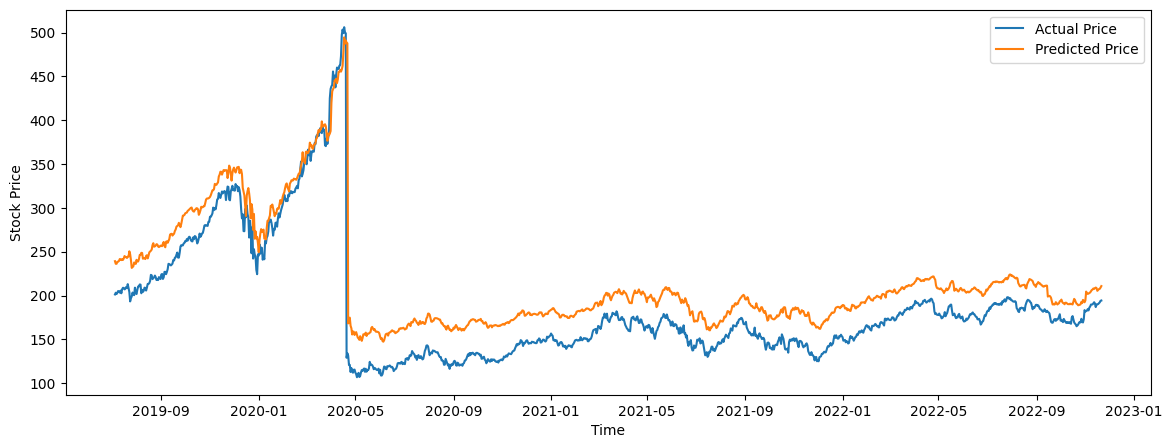

In [ ]:
predictions = model.predict(x_test)
# Convert the 'Date' column back to datetime format for plotting
combined_df['Date'] = pd.to_datetime(combined_df['Date'], unit='s')

# Then generate your test_dates as before
test_dates = pd.date_range(start=test_df['Original_Date'].iloc[0], periods=len(predictions))
# Assuming 'data' is your DataFrame and you want to predict the 'Close' price for AAPL
target_close_idx = combined_df.columns.get_loc('AAPL_4. close')

# 7. Test the model

# Prepare an array to inverse transform the predictions
dummy_array = np.zeros((len(predictions), scaled_data.shape[1]))
dummy_array[:, target_close_idx] = predictions.squeeze()
predictions = scaler.inverse_transform(dummy_array)[:, target_close_idx]
actual = scaler.inverse_transform(test_data[time_step+1:])
print(predictions)

# 8. Evaluate the model
# You might want to plot the predictions vs. actual values to visually inspect the performance
plt.figure(figsize=(14, 5))
plt.plot(test_dates,actual[:, target_close_idx], label='Actual Price')
plt.plot(test_dates, predictions, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend() 
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Assuming 'y_test' is your actual values and 'predictions' is your predicted values
mae = mean_absolute_error(actual[:, target_close_idx], predictions)
mse = mean_squared_error(actual[:, target_close_idx], predictions)
rmse = sqrt(mse) # or mse**(0.5)  
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 30.41925061947559
Mean Squared Error: 1185.2415558831358
Root Mean Squared Error: 34.427337333623925
